# Decomposition of Sky Spectra

This notebook evaluates an ESO sky model and decomposes sky spectra into:
- continuum components (e.g., zodiacal light, scattered moonlight, and PALACE-based diffuse components HO2, FeO, O2Ac), and
- groups of sky emission lines tied by their electronic states.

A median-stacked spectra `XCframe` file compiled by Knox Long is used.

This notebook continues the Sky Subtraction sprint in Heidelberg (June 2025) and was updated by Ivan Katkov and Niv Drory during IK’s visit to UT in August 2025.

In [1]:
from astropy.table import Table, Column
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np

## File / Dir preparation

In [8]:
import os

# Path to the stacked XCFrame file used as input
XCFRAME_FILE = "XCframe_1.1.1_3469_31300_1.fits"

# Path to PALACE PMD reference continuum data directory (contains pmd_refcont.dat)
PALACE_DIR = os.environ.get('PALACE_DIR', './palace')

# Scaling factor used in linear solvers
SCALE_FACTOR = 1e13

fits.info(XCFRAME_FILE)

tbl = Table.read(XCFRAME_FILE, 'DRP_ALL')
wave = fits.getdata(XCFRAME_FILE, 'WAVE')
flux, hdr = fits.getdata(XCFRAME_FILE, 'FLUX', header=True)
sky_east = fits.getdata(XCFRAME_FILE, 'SKY_EAST')
sky_west = fits.getdata(XCFRAME_FILE, 'SKY_WEST')

Filename: XCframe_1.1.1_3469_31300_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  WAVE          1 ImageHDU         7   (12401,)   float32   
  2  FLUX          1 ImageHDU        20   (12401, 7947)   float32   
  3  SKY_EAST      1 ImageHDU        20   (12401, 7947)   float32   
  4  SKY_WEST      1 ImageHDU        20   (12401, 7947)   float32   
  5  DRP_ALL       1 BinTableHDU    107   7947R x 49C   [6A, K, K, K, D, K, K, K, 5A, K, 24A, 23A, D, D, D, D, D, D, D, D, D, D, D, D, 13A, D, D, D, D, D, D, D, 13A, D, D, D, D, D, D, D, D, 23A, 77A, 65A, K, 7A, 8A, 8A, D]   


## Evaluate ESO Sky Model for all records

Prepare CSV files with RA/Dec and observation time for Science, SkyE, and SkyW
telescopes. These are will be by the `eso_skymodel_eval` CLI in batch mode.

In [4]:
records_sci = tbl['sci_ra', 'sci_dec', 'obstime']
records_skye = tbl['skye_ra', 'skye_dec', 'obstime']
records_skyw = tbl['skyw_ra', 'skyw_dec', 'obstime']

records_sci.rename_column('sci_ra', 'ra')
records_sci.rename_column('sci_dec', 'dec')

records_skye.rename_column('skye_ra', 'ra')
records_skye.rename_column('skye_dec', 'dec')

records_skyw.rename_column('skyw_ra', 'ra')
records_skyw.rename_column('skyw_dec', 'dec')

records_sci.write('drp_ra_dec_obstime_sci.csv', format='ascii.csv', overwrite=True)
records_skye.write('drp_ra_dec_obstime_skye.csv', format='ascii.csv', overwrite=True)
records_skyw.write('drp_ra_dec_obstime_skyw.csv', format='ascii.csv', overwrite=True)

Now call the `eso_skymodel_eval` CLI tool in batch mode to evaluate the ESO Sky
Model for all locations of Sci, SkyE, and SkyW telescopes.

```bash
❯ python -m eso_skymodel_eval batch --csv drp_ra_dec_obstime_sci.csv --ncpu=8 --save-fits skymodel_output_drp1.1.1_sci.fits --ignore-errors
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7947/7947 [03:47<00:00, 34.87it/s]
Completed 7947 records.
Skipped 9 failed record(s) due to errors:
  - idx=104 RA=296.247 Dec=-14.805 ObsTime=2023-08-29T04:27:55.572 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=2407 RA=115.423 Dec=-28.654 ObsTime=2024-02-18T02:36:52.385 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=3117 RA=185.996 Dec=-65.879 ObsTime=2024-03-26T05:15:55.959 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4136 RA=163.358 Dec=-62.621 ObsTime=2024-06-19T01:48:51.284 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4147 RA=307.829 Dec=-29.175 ObsTime=2024-06-19T07:22:18.393 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4169 RA=301.000 Dec=-28.054 ObsTime=2024-06-20T06:04:57.713 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=5516 RA=26.062 Dec=-41.811 ObsTime=2024-08-21T07:28:01.865 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=6477 RA=82.034 Dec=2.566 ObsTime=2024-10-11T05:48:03.556 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=7333 RA=56.920 Dec=-10.702 ObsTime=2024-11-19T02:52:00.905 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
```

Some records caused errors which require further investigation. For now, we ignore them.

SkyE:

```bash
❯ python -m eso_skymodel_eval batch --csv drp_ra_dec_obstime_skye.csv --ncpu=8 --save-fits skymodel_output_drp1.1.1_skye.fits --ignore-errors
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7947/7947 [03:56<00:00, 33.63it/s]
Completed 7947 records.
Skipped 21 failed record(s) due to errors:
  - idx=296 RA=2.055 Dec=-34.655 ObsTime=2023-09-22T05:23:09.851 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=923 RA=70.848 Dec=-56.111 ObsTime=2023-11-27T04:43:46.412 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=1170 RA=0.000 Dec=0.000 ObsTime=2023-12-08T05:49:43.264 | Source altitude < 0 deg for RA=0.0, Dec=0.0 at 2023-12-08T05:49:43.264
  - idx=1171 RA=0.000 Dec=0.000 ObsTime=2023-12-08T06:06:23.181 | Source altitude < 0 deg for RA=0.0, Dec=0.0 at 2023-12-08T06:06:23.181
  - idx=1172 RA=0.000 Dec=0.000 ObsTime=2023-12-08T06:23:01.202 | Source altitude < 0 deg for RA=0.0, Dec=0.0 at 2023-12-08T06:23:01.202
  - idx=1173 RA=0.000 Dec=0.000 ObsTime=2023-12-08T06:39:38.625 | Source altitude < 0 deg for RA=0.0, Dec=0.0 at 2023-12-08T06:39:38.625
  - idx=1174 RA=0.000 Dec=0.000 ObsTime=2023-12-08T06:56:22.036 | Source altitude < 0 deg for RA=0.0, Dec=0.0 at 2023-12-08T06:56:22.036
  - idx=1175 RA=0.000 Dec=0.000 ObsTime=2023-12-08T07:20:55.814 | Source altitude < 0 deg for RA=0.0, Dec=0.0 at 2023-12-08T07:20:55.814
  - idx=1176 RA=0.000 Dec=0.000 ObsTime=2023-12-08T07:37:34.750 | Source altitude < 0 deg for RA=0.0, Dec=0.0 at 2023-12-08T07:37:34.750
  - idx=1177 RA=0.000 Dec=0.000 ObsTime=2023-12-08T07:54:18.082 | Source altitude < 0 deg for RA=0.0, Dec=0.0 at 2023-12-08T07:54:18.082
  - idx=1647 RA=105.637 Dec=-36.267 ObsTime=2024-01-04T07:57:08.238 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=2028 RA=134.890 Dec=-43.570 ObsTime=2024-01-30T06:28:23.898 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=2381 RA=118.244 Dec=-24.063 ObsTime=2024-02-17T03:24:50.468 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=2661 RA=88.656 Dec=1.809 ObsTime=2024-03-03T02:13:12.060 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4195 RA=228.735 Dec=-62.675 ObsTime=2024-06-24T06:41:04.996 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4846 RA=301.990 Dec=-47.170 ObsTime=2024-07-16T00:50:44.809 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4881 RA=293.555 Dec=-28.353 ObsTime=2024-07-17T03:15:05.083 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4882 RA=293.554 Dec=-28.351 ObsTime=2024-07-17T03:31:10.020 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4949 RA=351.580 Dec=-15.723 ObsTime=2024-07-19T05:32:25.412 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=5544 RA=302.008 Dec=-47.174 ObsTime=2024-08-22T04:59:34.456 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=7331 RA=52.691 Dec=-7.570 ObsTime=2024-11-19T02:17:45.067 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
```

SkyW:

```bash
❯ python -m eso_skymodel_eval batch --csv drp_ra_dec_obstime_skyw.csv --ncpu=8 --save-fits skymodel_output_drp1.1.1_skyw.fits --ignore-errors
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7947/7947 [03:27<00:00, 38.39it/s]
Completed 7947 records.
Skipped 11 failed record(s) due to errors:
  - idx=319 RA=85.792 Dec=-1.270 ObsTime=2023-09-25T06:58:26.561 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=2924 RA=118.233 Dec=-24.060 ObsTime=2024-03-16T01:29:14.054 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=3028 RA=70.871 Dec=-56.146 ObsTime=2024-03-22T00:33:45.240 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4038 RA=234.750 Dec=-33.430 ObsTime=2024-06-16T02:06:46.059 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4235 RA=331.976 Dec=-70.730 ObsTime=2024-06-25T07:52:12.563 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=5029 RA=328.218 Dec=-41.760 ObsTime=2024-07-25T07:09:48.379 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=5153 RA=16.350 Dec=-24.239 ObsTime=2024-07-29T09:01:35.298 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=5578 RA=2.046 Dec=-34.642 ObsTime=2024-08-23T06:54:58.218 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=5666 RA=2.054 Dec=-34.653 ObsTime=2024-08-26T06:57:06.123 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=6149 RA=26.956 Dec=-20.527 ObsTime=2024-09-22T06:01:18.163 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=6490 RA=2.057 Dec=-34.655 ObsTime=2024-10-12T00:58:43.002 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
```

## ESO Sky Model output visualization

Sanity check that the Sky Model and the individual PALACE diffuse components look adequate.

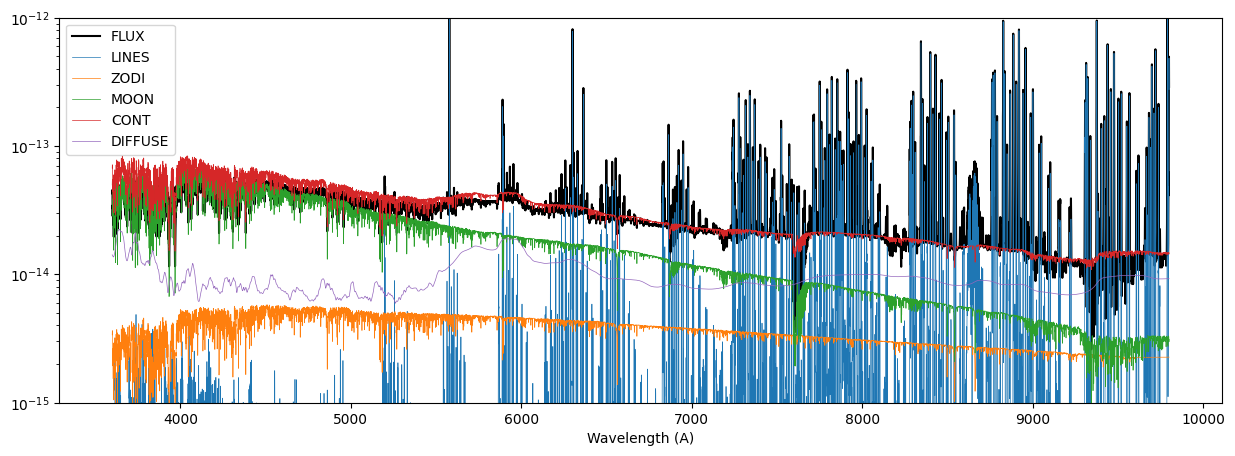

In [14]:
# %matplotlib widget
%matplotlib inline

f_skye = "skymodel_output_drp1.1.1_skye.fits"
sm_wave = fits.getdata(f_skye, "WAVE")
sm_flux = fits.getdata(f_skye, "FLUX")
sm_moon = fits.getdata(f_skye, "MOON")
sm_zodi = fits.getdata(f_skye, "ZODI")
sm_diffuse = fits.getdata(f_skye, "DIFFUSE")
sm_lines = fits.getdata(f_skye, "LINES")
sm_cont = fits.getdata(f_skye, "CONT")

# Sanity plots of the evaluated Sky Model
idx = 160
tbl[idx]

plt.close('all')
plt.figure(figsize=(15, 5))
plt.plot(sm_wave, sm_flux[idx], label='FLUX', color='k')
plt.plot(sm_wave, sm_lines[idx], label='LINES', lw=0.5)
plt.plot(sm_wave, sm_zodi[idx], label='ZODI', lw=0.5)
plt.plot(sm_wave, sm_moon[idx], label='MOON', lw=0.5)
plt.plot(sm_wave, sm_cont[idx], label='CONT', lw=0.5)
plt.plot(sm_wave, sm_diffuse[idx], label='DIFFUSE', lw=0.5)

plt.yscale('log')
plt.ylim(1e-15, 1e-12)
plt.xlabel('Wavelength (A)')
plt.legend()
plt.show()

### PALACE airglow components
Let's check how individual diffuse airglow component from PALACE model look like.

In [17]:
# Read PALACE individual diffuse continuum components
pmd_redcont = Table.read(f"{PALACE_DIR}/PMD/pmd_refcont.dat", format='ascii')
pmd_redcont

lam,trans,fH2O,fcHO2,fcFeO,fcO2Ac,isX
float64,float64,float64,float64,float64,float64,int64
0.3,0.0,0.0,0.216,0.405,3.698,0
0.30002,0.0428,0.0,0.216,0.405,3.698,0
0.30004,0.0861,0.0,0.216,0.405,3.697,0
0.30006,0.0863,0.0,0.216,0.405,3.696,0
0.30008,0.0867,0.0,0.216,0.405,3.695,0
0.3001,0.0872,0.0,0.216,0.405,3.695,0
0.30012,0.0876,0.0,0.216,0.405,3.694,0
0.30014,0.0878,0.0,0.216,0.405,3.693,0
0.30016,0.0881,0.0,0.216,0.406,3.692,0


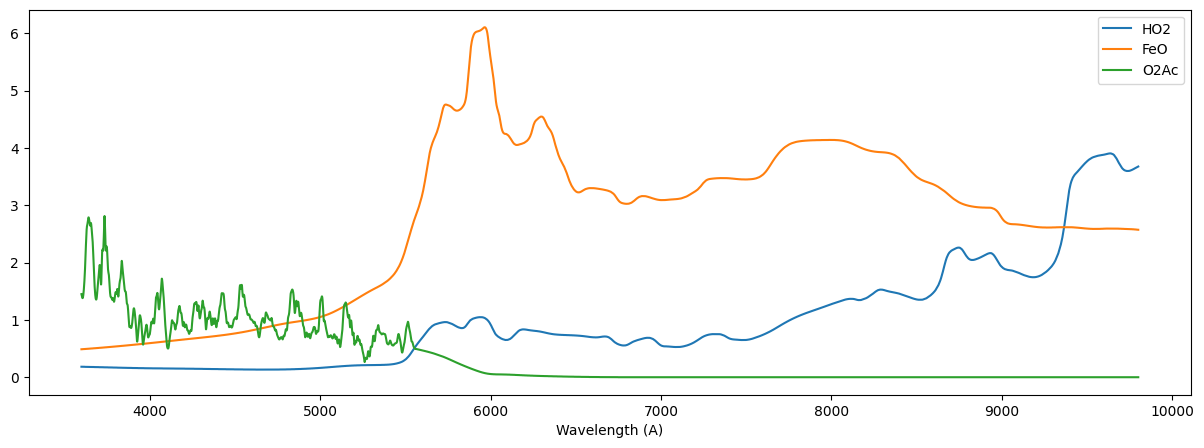

In [18]:
# %matplotlib widget
%matplotlib inline

cont_HO2 = np.interp(wave / 1e4, pmd_redcont['lam'], pmd_redcont['fcHO2'])
cont_FeO = np.interp(wave / 1e4, pmd_redcont['lam'], pmd_redcont['fcFeO'])
cont_O2Ac = np.interp(wave / 1e4, pmd_redcont['lam'], pmd_redcont['fcO2Ac'])

plt.close('all')
plt.figure(figsize=(15, 5))
plt.plot(wave, cont_HO2, label='HO2')
plt.plot(wave, cont_FeO, label='FeO')
plt.plot(wave, cont_O2Ac, label='O2Ac')

plt.xlabel('Wavelength (A)')
plt.legend()
plt.show()

## Remove trash spectra

Here and below we focus on SkyE spectra only.

Some spectra exhibit calibration issues. In this section we visualize simple flux ratios $F_{5650\pm50} / F_{6100\pm50}$, $F_{7130\pm20} / F_{8200\pm20}$ and define a mask to remove obviously problematic spectra. This exclude spectra those calibrations jump from one to another chip.

/var/folders/sg/qfk9vd6n17g0pvf1kt22r13r0000gn/T/ipykernel_32351/667740901.py:23: RuntimeWarning: divide by zero encountered in divide
  ratio_around_br = flux_b_blue / flux_b_red
/var/folders/sg/qfk9vd6n17g0pvf1kt22r13r0000gn/T/ipykernel_32351/667740901.py:24: RuntimeWarning: divide by zero encountered in divide
  ratio_around_rz = flux_r_blue / flux_r_red
/var/folders/sg/qfk9vd6n17g0pvf1kt22r13r0000gn/T/ipykernel_32351/667740901.py:24: RuntimeWarning: invalid value encountered in divide
  ratio_around_rz = flux_r_blue / flux_r_red


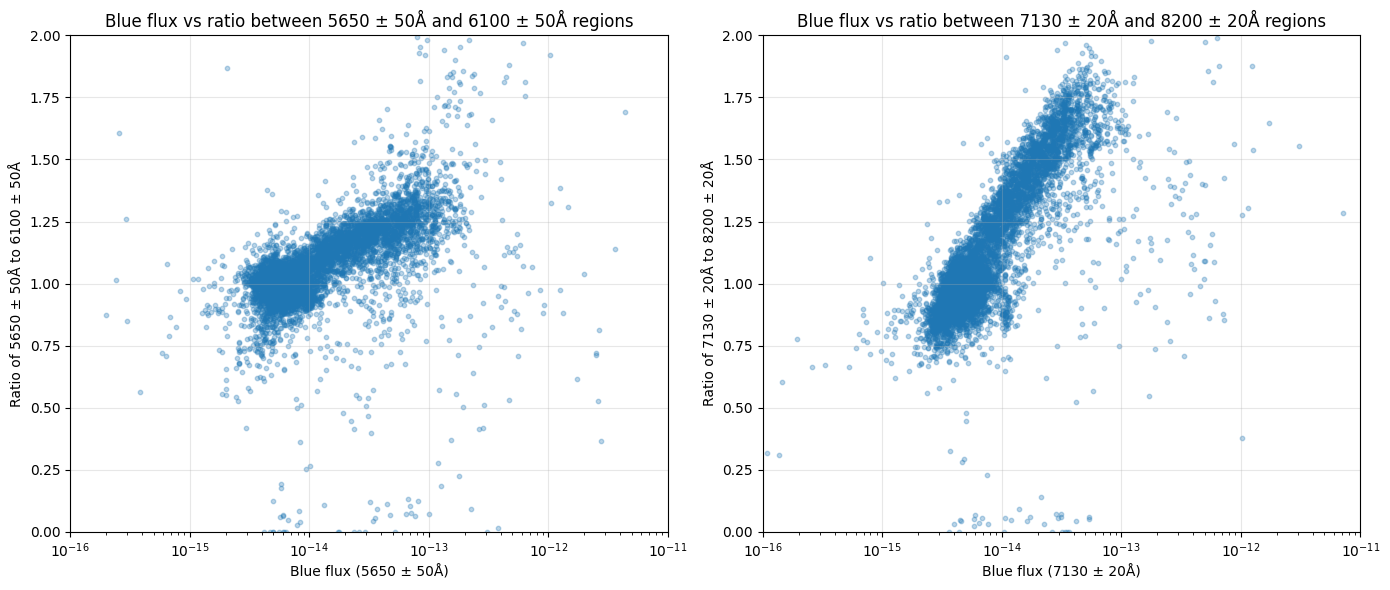

In [20]:
# %matplotlib widget
%matplotlib inline

# Define wavelength regions
blue_b_center, blue_b_width = 5650, 50
red_b_center, red_b_width = 6100, 50
blue_r_center, blue_r_width = 7130, 20
red_r_center, red_r_width = 8200, 20

# Create masks for each region
mask_b_blue = np.abs(wave - blue_b_center) <= blue_b_width
mask_b_red = np.abs(wave - red_b_center) <= red_b_width
mask_r_blue = np.abs(wave - blue_r_center) <= blue_r_width
mask_r_red = np.abs(wave - red_r_center) <= red_r_width

# Calculate median fluxes in each region
flux_b_blue = np.nanmedian(sky_east[:, mask_b_blue], axis=1)
flux_b_red = np.nanmedian(sky_east[:, mask_b_red], axis=1)
flux_r_blue = np.nanmedian(sky_east[:, mask_r_blue], axis=1)
flux_r_red = np.nanmedian(sky_east[:, mask_r_red], axis=1)

# Calculate ratios
ratio_around_br = flux_b_blue / flux_b_red
ratio_around_rz = flux_r_blue / flux_r_red

# Create plots
plt.close('all')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot
axes[0].scatter(flux_b_blue, ratio_around_br, alpha=0.3, s=10)
axes[0].set_xlabel(f'Blue flux ({blue_b_center} ± {blue_b_width}Å)')
axes[0].set_ylabel(f'Ratio of {blue_b_center} ± {blue_b_width}Å to {red_b_center} ± {red_b_width}Å')
axes[0].set_title(f'Blue flux vs ratio between {blue_b_center} ± {blue_b_width}Å and {red_b_center} ± {red_b_width}Å regions')
axes[0].grid(alpha=0.3)
axes[0].set_xscale('log')
axes[0].set_xlim(1e-16, 1e-11)
axes[0].set_ylim(0, 2)

# Second plot
axes[1].scatter(flux_r_blue, ratio_around_rz, alpha=0.3, s=10)
axes[1].set_xlabel(f'Blue flux ({blue_r_center} ± {blue_r_width}Å)')
axes[1].set_ylabel(f'Ratio of {blue_r_center} ± {blue_r_width}Å to {red_r_center} ± {red_r_width}Å')
axes[1].set_title(f'Blue flux vs ratio between {blue_r_center} ± {blue_r_width}Å and {red_r_center} ± {red_r_width}Å regions')
axes[1].grid(alpha=0.3)
axes[1].set_xscale('log')
axes[1].set_xlim(1e-16, 1e-11)
axes[1].set_ylim(0, 2)

plt.tight_layout()
plt.show()

### Bad spectra selection criteria
Finalize selection criteria for identifying problematic spectra

In [21]:
mask_normal = (ratio_around_br > 0.80) & (ratio_around_br < 1.4) & (flux_b_blue > 2.5e-15) & (flux_b_blue < 1e-13) & \
              (ratio_around_rz > 0.75) & (ratio_around_rz < 1.8) & (flux_r_blue > 2.0e-15) & (flux_r_blue < 5e-14)

np.sum(mask_normal)

6962

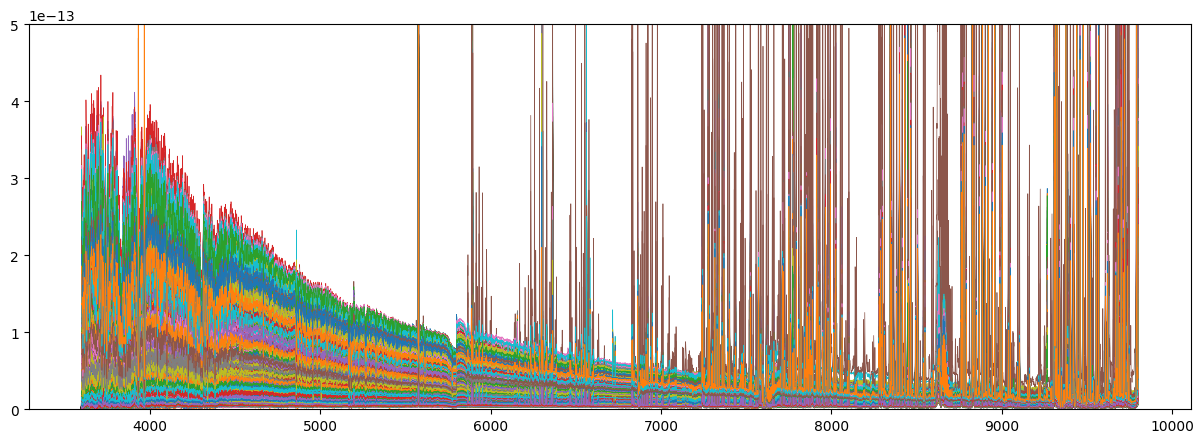

In [22]:
# %matplotlib widget
%matplotlib inline

plt.close('all')
fig = plt.figure(figsize=(15, 5))
plt.plot(wave, sky_east[mask_normal].T, lw=0.5)
plt.ylim(0, 5e-13)
plt.show()

## Sky Spectra Decomposition

### Preparation

In [23]:
data = Table.read("lvm_sky_lines_all.dat", format='ascii')
data

wave,flux_lvm,flux_eso,trans,type,electronic_state,rotational_upper_level
float64,float64,float64,float64,int64,int64,int64
3499.769,7.934e-17,0.0013,0.999431,5,39,0
3502.358,6.098e-17,0.001,0.999424,5,41,0
3502.758,7.927e-17,0.0013,0.99943,5,41,0
3504.807,4.875e-17,0.0008,0.999467,5,39,0
3505.317,3.656e-17,0.0006,0.999479,5,41,0
3505.717,7.311e-17,0.0012,0.999482,5,41,0
3508.916,5.478e-17,0.0009,0.999497,5,41,0
3509.846,6.085e-17,0.001,0.999463,5,41,0
3512.116,8.514e-17,0.0014,0.999027,5,41,0


In [24]:
# Electronic state groups for line tying (fix groups for type != 4,5)
electronic_state = data['electronic_state']
type = data['type']

# Adjust electronic state for missing entries
electronic_state[electronic_state==-999] = type[electronic_state==-999]

lines_groups = []

# Iterate over all possible electronic states and build groups
for i in range(0, np.max(electronic_state)):
    state_idx = electronic_state == i
    if not any(state_idx):
        continue

    grp_wave = data['wave'][state_idx]
    grp_flux = data['flux_eso'][state_idx]

    lines_groups.append({
        'wave': grp_wave,
        'flux': grp_flux,
        'electronic_state': i
    })
    print(f"Electronic state {i:3g} --> {len(grp_flux):5g} lines")

print(f"Found {len(lines_groups)} groups of lines")

Electronic state   1 -->    56 lines
Electronic state   2 -->     3 lines
Electronic state   3 -->    23 lines
Electronic state   4 -->     1 lines
Electronic state   5 -->     8 lines
Electronic state   6 -->    22 lines
Electronic state   7 -->    12 lines
Electronic state   8 -->    23 lines
Electronic state   9 -->    41 lines
Electronic state  10 -->    49 lines
Electronic state  11 -->     2 lines
Electronic state  12 -->    27 lines
Electronic state  13 -->    83 lines
Electronic state  14 -->   113 lines
Electronic state  15 -->   111 lines
Electronic state  16 -->    72 lines
Electronic state  17 -->     7 lines
Electronic state  18 -->    85 lines
Electronic state  19 -->   113 lines
Electronic state  20 -->   111 lines
Electronic state  21 -->   110 lines
Electronic state  22 -->   112 lines
Electronic state  23 -->    28 lines
Electronic state  24 -->    74 lines
Electronic state  39 -->   309 lines
Electronic state  40 -->     3 lines
Electronic state  41 -->   337 lines
E

### Create Design Matrix

In [25]:
design_matrix_lines = np.zeros((len(lines_groups), wave.size), dtype=float)

lsf_sigma = 1.51 / 2.355

for i, group in enumerate(lines_groups):
    wave_group = group['wave']
    flux_group = group['flux']

    print(f"Grp {i}: Nlines {len(wave_group)}")

    for wave_line, flux_line in zip(wave_group, flux_group):
        if (wave_line >= wave[0]) & (wave_line <= wave[-1]):
            yy = (wave - wave_line) / lsf_sigma
            design_matrix_lines[i] += flux_line * np.exp(-0.5 * yy ** 2) / (np.sqrt(2 * np.pi) * lsf_sigma)

    design_matrix_lines[i] /= np.max(design_matrix_lines[i])

# exclude zeros matrix rows which might happen because lines in the group does not fall into the wavelength coverage
design_matrix_lines = design_matrix_lines[np.isfinite(np.sum(design_matrix_lines, axis=1))]

Grp 0: Nlines 56
Grp 1: Nlines 3
Grp 2: Nlines 23
Grp 3: Nlines 1
Grp 4: Nlines 8
Grp 5: Nlines 22
Grp 6: Nlines 12
Grp 7: Nlines 23
Grp 8: Nlines 41
Grp 9: Nlines 49
Grp 10: Nlines 2
Grp 11: Nlines 27
Grp 12: Nlines 83
Grp 13: Nlines 113
Grp 14: Nlines 111
Grp 15: Nlines 72
Grp 16: Nlines 7
Grp 17: Nlines 85
Grp 18: Nlines 113
Grp 19: Nlines 111
Grp 20: Nlines 110
Grp 21: Nlines 112
Grp 22: Nlines 28
Grp 23: Nlines 74
Grp 24: Nlines 309
Grp 25: Nlines 3
Grp 26: Nlines 337
Grp 27: Nlines 65
Grp 28: Nlines 208
Grp 29: Nlines 194


/var/folders/sg/qfk9vd6n17g0pvf1kt22r13r0000gn/T/ipykernel_32351/3169154269.py:16: RuntimeWarning: invalid value encountered in divide
  design_matrix_lines[i] /= np.max(design_matrix_lines[i])


### Run decomposition

In [27]:
from scipy.optimize import lsq_linear, nnls
from scipy.sparse.linalg import lsmr
from astropy.convolution import Gaussian1DKernel, convolve
from tqdm.auto import tqdm
from scipy.sparse import csr_array


def decompose_spectrum(spec, continuum_matrix, design_matrix_lines, mask=None,
                       method='separate_cont_comps'):
    """Solve non-negative linear least squares for line groups and continuum."""

    if method == 'separate_cont_comps':
        continuum_matrix_updated = continuum_matrix
    elif method == 'sum_cont_comps':
        continuum_matrix_updated = np.sum(continuum_matrix, axis=0)
    else:
        raise NotImplementedError(
            f"Method '{method}' not implemented. Use 'separate_cont_comps' or 'sum_cont_comps'."
        )

    design_matrix_complete = np.vstack((design_matrix_lines, continuum_matrix_updated))

    bounds = (0, np.inf)  # require non-negative amplitudes
    results = lsq_linear(design_matrix_complete[:, mask].T, spec[mask], bounds=bounds)
    coef = results.x

    n_lines = design_matrix_lines.shape[0]
    model_lines = np.dot(design_matrix_complete[:n_lines].T, coef[:n_lines])
    model_cont = np.dot(design_matrix_complete[n_lines:].T, coef[n_lines:])

    return model_lines, model_cont, coef


# Define manually instrumental resolution
lsf_fwhm = 1.3
kernel = Gaussian1DKernel(stddev=lsf_fwhm / 2.355 / 0.5)

# Exclude regions around strong features and tellurics
wmask = np.ones(wave.size).astype(bool)
wmask[(wave > 5750) & (wave < 5850)] = False
wmask[(wave > 7500) & (wave < 7750)] = False
wmask[(wave > 8600) & (wave < 8700)] = False

method = 'separate_cont_comps' # Alternative 'sum_cont_comps'

n_line_groups = design_matrix_lines.shape[0]

l_output_coefficients, l_output_indices = [], []

# Iterate on good spectra only
good_indices = np.arange(mask_normal.size)[mask_normal]
for i, idx in tqdm(enumerate(good_indices), total=good_indices.size):

    # Exclude situations when SkyModel failed.
    # TODO this should be places into `mask_normal`
    if np.isnan(np.sum(sm_moon[idx])):
        continue

    spec_obs = sky_east[idx] * SCALE_FACTOR
    cont_matrix = np.vstack( (sm_moon[idx] * SCALE_FACTOR,
                              sm_zodi[idx] * SCALE_FACTOR,
                              cont_HO2,
                              cont_FeO,
                              cont_O2Ac,) )

    # convolve with instrumental resolution only moon and zodi components
    for i in range(2):
        cont_matrix[i] = convolve(cont_matrix[i], kernel, boundary='extend')

    model_lines, model_cont, coef = \
        decompose_spectrum(spec_obs,
                           cont_matrix,
                           design_matrix_lines,
                           method=method, mask=wmask)
    l_output_coefficients.append(coef)
    l_output_indices.append(idx)

  0%|          | 0/6962 [00:00<?, ?it/s]

### Save decomposition coefficients

Column `idx` corresponds to the index in the original table `tbl` in the `XCframe`. Due to some Sky Model failures one should exclude this indices from the table, therefore `idx` column is not identical to `mask_normal`. So, the plotting function below `plot_decomp_results` takes this into account.

In [28]:
col_names = [f"g{i+1}" for i in range(n_line_groups)] + ['c_moon', 'c_zodi', 'c_HO2', 'c_FeO', 'c_O2Ac']
tout = Table(rows=l_output_coefficients, names=col_names)

tout.add_column(Column(l_output_indices, name='idx'), index=0)
tout.write("decomposition_coefficients.fits", format='fits', overwrite=True)

### Some plots of decomposed spectra

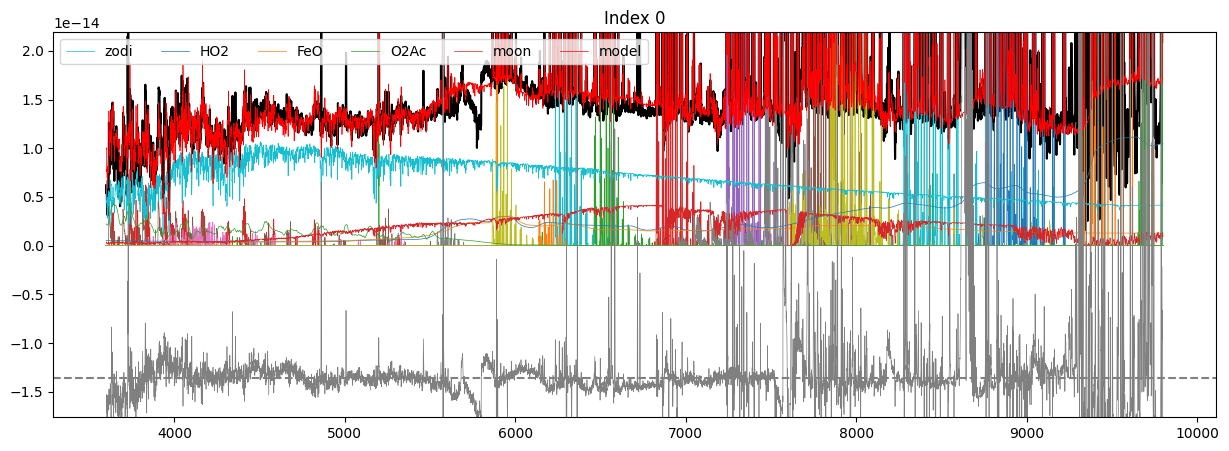

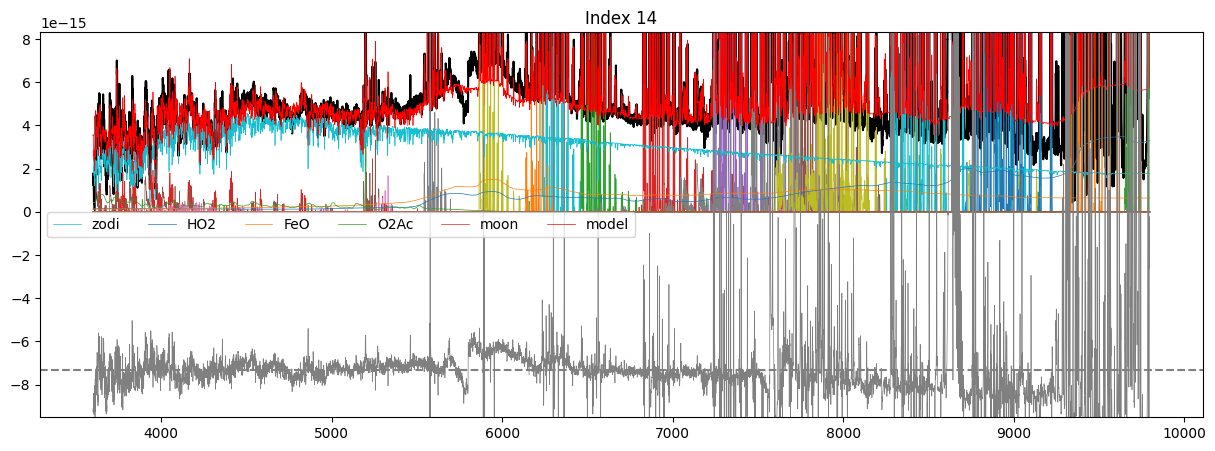

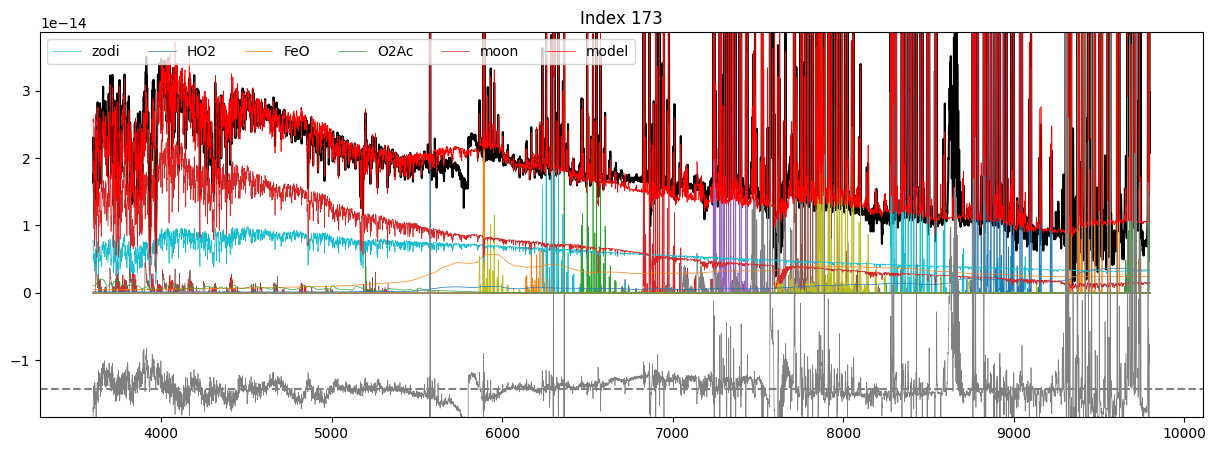

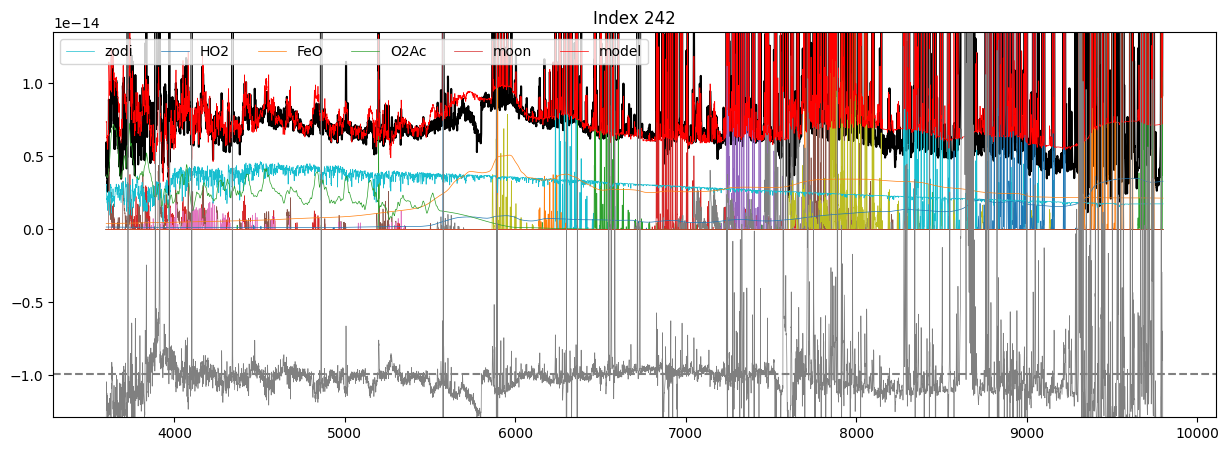

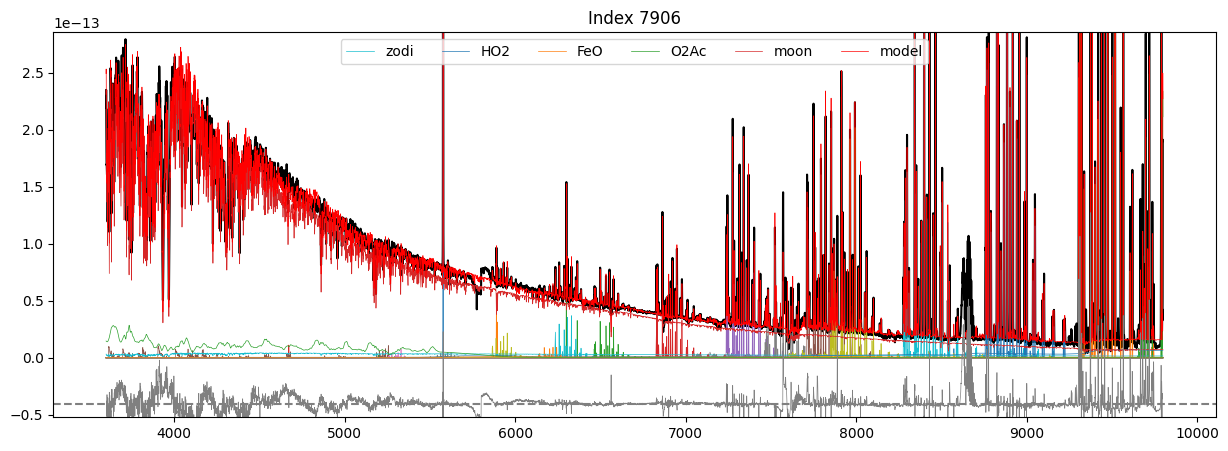

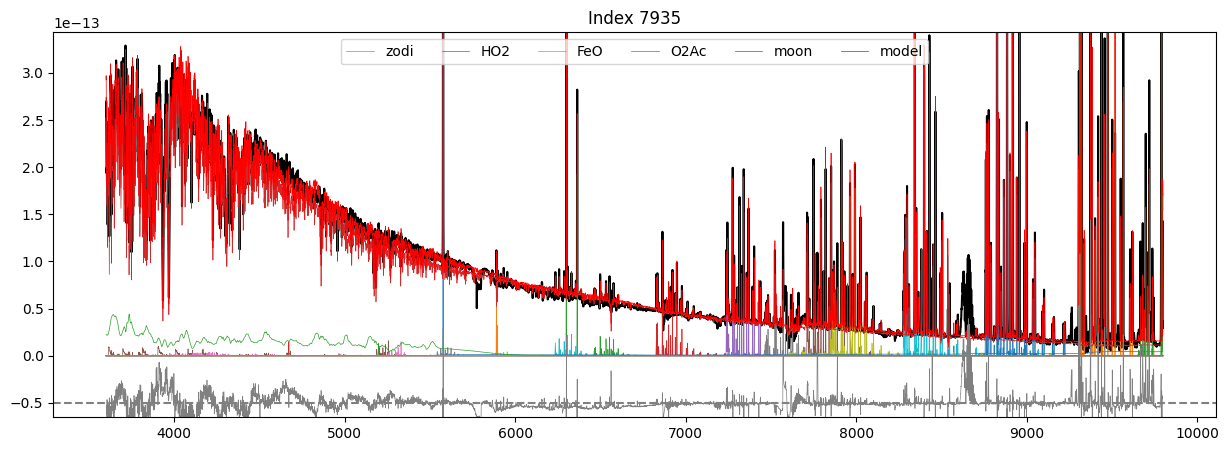

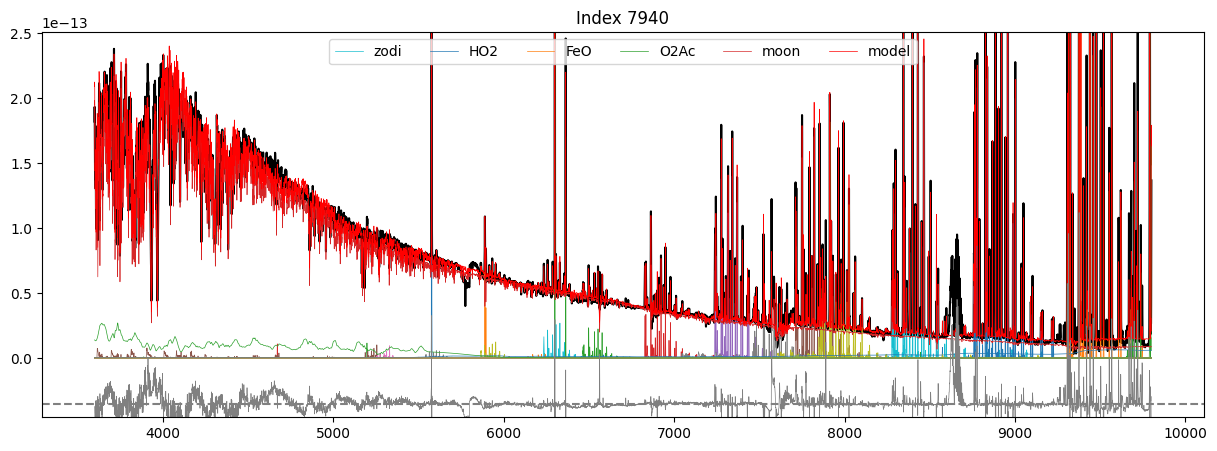

In [46]:
from astropy.convolution import Gaussian1DKernel, convolve
from astropy.stats import sigma_clipped_stats


def plot_decomp_results(idx, t, spec, wave, sm_moon, sm_zodi,
                        cont_HO2, cont_FeO, cont_O2Ac,
                        design_matrix_lines, kernel, factor=1e13):
    """Plot decomposition results for a given index using fitted coefficients."""

    idx_in_table_res = np.argwhere(t['idx'] == idx)
    if len(idx_in_table_res) == 0:
        raise ValueError(f"No entry found in table for index {idx}")

    idx_in_table = idx_in_table_res[0][0]
    trow = t[idx_in_table]

    n_line_groups = design_matrix_lines.shape[0]

    model_zodi = convolve(sm_zodi[idx] * trow['c_zodi'], kernel, boundary='extend')
    model_moon = convolve(sm_moon[idx] * trow['c_moon'], kernel, boundary='extend')
    model_HO2 = cont_HO2 * trow['c_HO2'] / factor
    model_FeO = cont_FeO * trow['c_FeO'] / factor
    model_O2Ac = cont_O2Ac * trow['c_O2Ac'] / factor
    model_cont = model_moon + model_HO2 + model_FeO + model_O2Ac + model_zodi

    fig = plt.figure(figsize=(15, 5))
    plt.plot(wave, spec[idx], 'k')

    # sky emission line groups
    model_lines = model_cont * 0
    for q in range(n_line_groups):
        model_grp = design_matrix_lines[q] * trow[f"g{q+1}"] / factor
        model_lines += model_grp
        plt.plot(wave, model_grp, lw=0.5)#, label=f"{q+1}")
    plt.plot(wave, model_zodi, label='zodi', lw=0.5)
    plt.plot(wave, model_HO2, label='HO2', lw=0.5)
    plt.plot(wave, model_FeO, label='FeO', lw=0.5)
    plt.plot(wave, model_O2Ac, label='O2Ac', lw=0.5)
    plt.plot(wave, model_moon, label='moon', lw=0.5)
    model_total = model_cont + model_lines
    resid = spec[idx] - model_total
    plt.plot(wave, model_total, label='model', color='red', lw=0.5)
    # rms = np.nanstd(resid)
    _, _, rms = sigma_clipped_stats(resid)
    resid_level = -10 * rms

    plt.axhline(resid_level, linestyle='--', color='grey')
    plt.plot(wave, resid_level+resid, color='grey', lw=0.5)
    plt.ylim(resid_level - 3 * rms, np.nanmax(model_cont) + 3 * rms)
    plt.legend(ncol=6)
    plt.title(f"Index {idx}")


# %matplotlib widget
%matplotlib inline

tout = Table.read("decomposition_coefficients.fits")

plt.close('all')
for tr in tout[[0,10,100,150,-30,-10, -5]]:
    plot_decomp_results(tr['idx'], tout, sky_east, wave, sm_moon, sm_zodi,
                        cont_HO2, cont_FeO, cont_O2Ac,
                        design_matrix_lines, kernel, factor=SCALE_FACTOR)
plt.show()

### Generate fits with residuals

In [47]:
from astropy.convolution import Gaussian1DKernel, convolve
from astropy.stats import sigma_clipped_stats

# TODO should be rewritten to DRY with plotting and decomposition function
def get_model(idx, t, spec, wave, sm_moon, sm_zodi,
              cont_HO2, cont_FeO, cont_O2Ac,
              design_matrix_lines, kernel, factor=1e13):

    idx_in_table_res = np.argwhere(t['idx'] == idx)
    if len(idx_in_table_res) == 0:
        raise ValueError(f"No entry found in table for index {idx}")

    idx_in_table = idx_in_table_res[0][0]
    trow = t[idx_in_table]

    n_line_groups = design_matrix_lines.shape[0]

    model_zodi = convolve(sm_zodi[idx] * trow['c_zodi'], kernel, boundary='extend')
    model_moon = convolve(sm_moon[idx] * trow['c_moon'], kernel, boundary='extend')
    model_HO2 = cont_HO2 * trow['c_HO2'] / factor
    model_FeO = cont_FeO * trow['c_FeO'] / factor
    model_O2Ac = cont_O2Ac * trow['c_O2Ac'] / factor
    model_cont = model_moon + model_HO2 + model_FeO + model_O2Ac + model_zodi

    model_lines = model_cont * 0
    for q in range(n_line_groups):
        model_grp = design_matrix_lines[q] * trow[f"g{q+1}"] / factor
        model_lines += model_grp

    model_total = model_cont + model_lines
    resid = spec[idx] - model_total

    return model_total, resid

tout = Table.read("decomposition_coefficients.fits")

plt.close('all')
l_resid = []
l_model = []
for tr in tqdm(tout):
    model1d, resid1d = get_model(tr['idx'], tout, sky_east, wave, sm_moon, sm_zodi,
                                 cont_HO2, cont_FeO, cont_O2Ac,
                                 design_matrix_lines, kernel, factor=SCALE_FACTOR)
    l_model.append(model1d)
    l_resid.append(resid1d)

model2d = np.vstack(l_model)
resid2d = np.vstack(l_resid)

fits.HDUList([
    fits.PrimaryHDU(data=model2d, header=hdr),
    fits.ImageHDU(data=resid2d, header=hdr)
]).writeto('sky_model_decomposition_residuals.fits', overwrite=True)

  0%|          | 0/6946 [00:00<?, ?it/s]

### [TODO] Plot with residuals

## Investigate Correlations

First, adding to the table woth decomposition coefficients some observable parameters from original `DRP_ALL` (i.e. `tbl`) table.

In [55]:
from astropy.table import hstack

tout = Table.read("decomposition_coefficients.fits")

tbl_sub = tbl[tout['idx']]
tbl_subcol = tbl_sub['skye_ra', 'skye_dec', 'moon_fli', 'skye_amass', 'skye_moon_sep', 'sun_alt', 'moon_alt']

tout = hstack([tout, tbl_subcol])
# Convert Astropy table in Pandas dataframe for easiest way calculating the correlation matrix
df = tout.to_pandas()
tout

idx,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20,g21,g22,g23,g24,g25,g26,g27,g28,g29,c_moon,c_zodi,c_HO2,c_FeO,c_O2Ac,skye_ra,skye_dec,moon_fli,skye_amass,skye_moon_sep,sun_alt,moon_alt
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,10.075605803555943,1.479740294697264,8.721582734304212,0.012383327658695183,6.9302523617803775e-18,0.03778864113194187,0.022098092630696137,0.0284491048278016,0.18663459144453948,0.3407938220557841,4.905728754343167e-29,0.06757563939563396,0.30132054330821106,0.8131552142015371,1.625354423526963,2.0482845227709836,0.0020896596297980434,1.0148161114931216,2.2682142257718287,4.281739733595468,6.546743976842166,8.655619040370972,5.473027515630371,0.07845231704842512,1.5396335781014503e-16,0.04965731612168261,0.024203293267168784,0.04462509341377223,0.07568564572212003,19426084.20875627,1.7333660904259223,0.02856258699746688,0.004980279688619746,0.015389090726094472,269.620756,-26.146471,0.1857,1.165,126.3633,-61.0632,-11.4681
1,7.089134876150723,1.1461168864809994,5.5891845050551225,0.0021625752254717822,0.00045500710938699474,0.0365479044200415,0.025123257005346802,0.030569582637603288,0.14745724541481503,0.2906943501392344,0.003994500584514421,0.06413730312286167,0.27635168490527745,0.7015253919284914,1.3580313229767247,1.7131441437938688,1.2288959827043653e-12,0.8998150365461492,1.9572457754349648,3.652479968398733,5.543483811832442,7.291696612520006,4.857953685077015,0.059140509328987644,2.42862412985346e-25,0.03623871594324868,0.00859539403883046,0.03973761167456445,0.058043748890190525,0.1,1.5298964293577473,0.017162583321516194,0.006176604386863633,0.004941103760152837,269.622739,-26.144989,0.1868,1.225,126.5285,-64.697,-15.5032
2,7.194519687173869,1.2274276685631533,4.702898652623991,0.00612976779435338,6.4304705591054645e-21,0.0373679796767335,0.024541828685958028,0.02777550942228227,0.1499558612502462,0.2982797186764699,0.003788861901607643,0.06405617304488898,0.2792436084346787,0.7050051007958505,1.3756577069323277,1.7508057446363232,1.5435249229657693e-11,0.8906372184681595,1.9710324085149071,3.6868564705055937,5.609903748578184,7.424348891328651,4.886644714941108,0.06353021246360029,3.058161885697871e-22,0.042079850491438066,0.011842583832359754,0.04044170897080516,0.05876117573752648,0.1,1.5548238948532926,0.017608183073630733,0.0075102902483533684,0.008525640673570216,269.626634,-26.145639,0.1881,1.299,126.7014,-68.0037,-19.5398
3,6.526934814243592,1.1675959425247326,3.157709726262477,0.002509220525892552,1.0487622984272123e-10,0.034966703262897074,0.0220976120018377,0.033323658862332656,0.1352397728257525,0.2529937623199179,0.0016299362880940877,0.05458638738165045,0.23000632273551205,0.5766897153527696,1.1499147678483366,1.4527695039460296,2.0184533853845996e-13,0.6976480918200528,1.5796705185826694,2.9819253712263523,4.570845304846104,6.153402804777992,3.8758337896636648,0.05951599810826094,0.0008154821835494575,0.03530339250937693,0.011277989408235572,0.03292902557849784,0.04826450455764562,0.1,1.2869053881459172,0.012350443726108376,0.004834182721168805,0.009809433371978107,269.625211,-26.147253,0.1893,1.391,126.8775,-70.6712,-23.4261
4,6.697396159696762,1.4944708273370186,2.887776880320713,0.003559975739153916,2.016226103075909e-18,0.037857145935958236,0.026133299551257805,0.03886931682433306,0.15016900593459212,0.2849100601029713,0.0002529769362969763,0.061416621513478716,0.25136566380055786,0.6367418289835303,1.2815255183592824,1.6335052551962275,1.0803263281797151e-33,0.7568115780273006,1.7645661701851665,3.3533159370496755,5.1459925026140425,6.931076556874447,4.260862254232663,0.062355856926520785,0.0025911480293843983,0.03828763344594986,0.009826234745616603,0.034168

### Calculate some column statistics

In [53]:
# Calculate statistics for each column in tcoef and organize as a table
stats_names = ['min', 'max', 'mean', 'median', 'std', 'p1', 'p5', 'p95', 'p99']
headers = ['column'] + stats_names
print(f"{headers[0]:15s}", end='')
for stat in stats_names:
    print(f"{stat:15s}", end='')
print()

print("-" * (8 + 15 * len(stats_names)))

for col in tout.colnames:
    values = tout[col]
    stats = {
        'min': np.min(values),
        'max': np.max(values),
        'mean': np.mean(values),
        'median': np.median(values),
        'std': np.std(values),
        'p1': np.percentile(values, 1),
        'p5': np.percentile(values, 5),
        'p95': np.percentile(values, 95),
        'p99': np.percentile(values, 99)
    }
    print(f"{col:15s}", end='')
    for stat_name in stats_names:
        print(f"{stats[stat_name]:15.6e}", end='')
    print()

column         min            max            mean           median         std            p1             p5             p95            p99            
-----------------------------------------------------------------------------------------------------------------------------------------------
idx               0.000000e+00   7.946000e+03   4.059513e+03   4.105500e+03   2.289029e+03   8.745000e+01   4.892500e+02   7.567750e+03   7.858550e+03
g1                1.006251e+00   1.153004e+02   7.658830e+00   6.976310e+00   3.782718e+00   2.284397e+00   3.258796e+00   1.429548e+01   1.851576e+01
g2                6.203826e-02   1.534241e+01   8.293054e-01   7.146234e-01   5.237458e-01   1.712141e-01   2.684175e-01   1.762211e+00   2.461053e+00
g3                1.803271e-01   3.822153e+01   4.829109e+00   3.386801e+00   4.220156e+00   4.346894e-01   7.402533e-01   1.369639e+01   1.900468e+01
g4               4.940656e-324   1.960859e-01   1.147413e-02   4.597123e-03   1.960562e-02   2.285321

### Correlation matrix

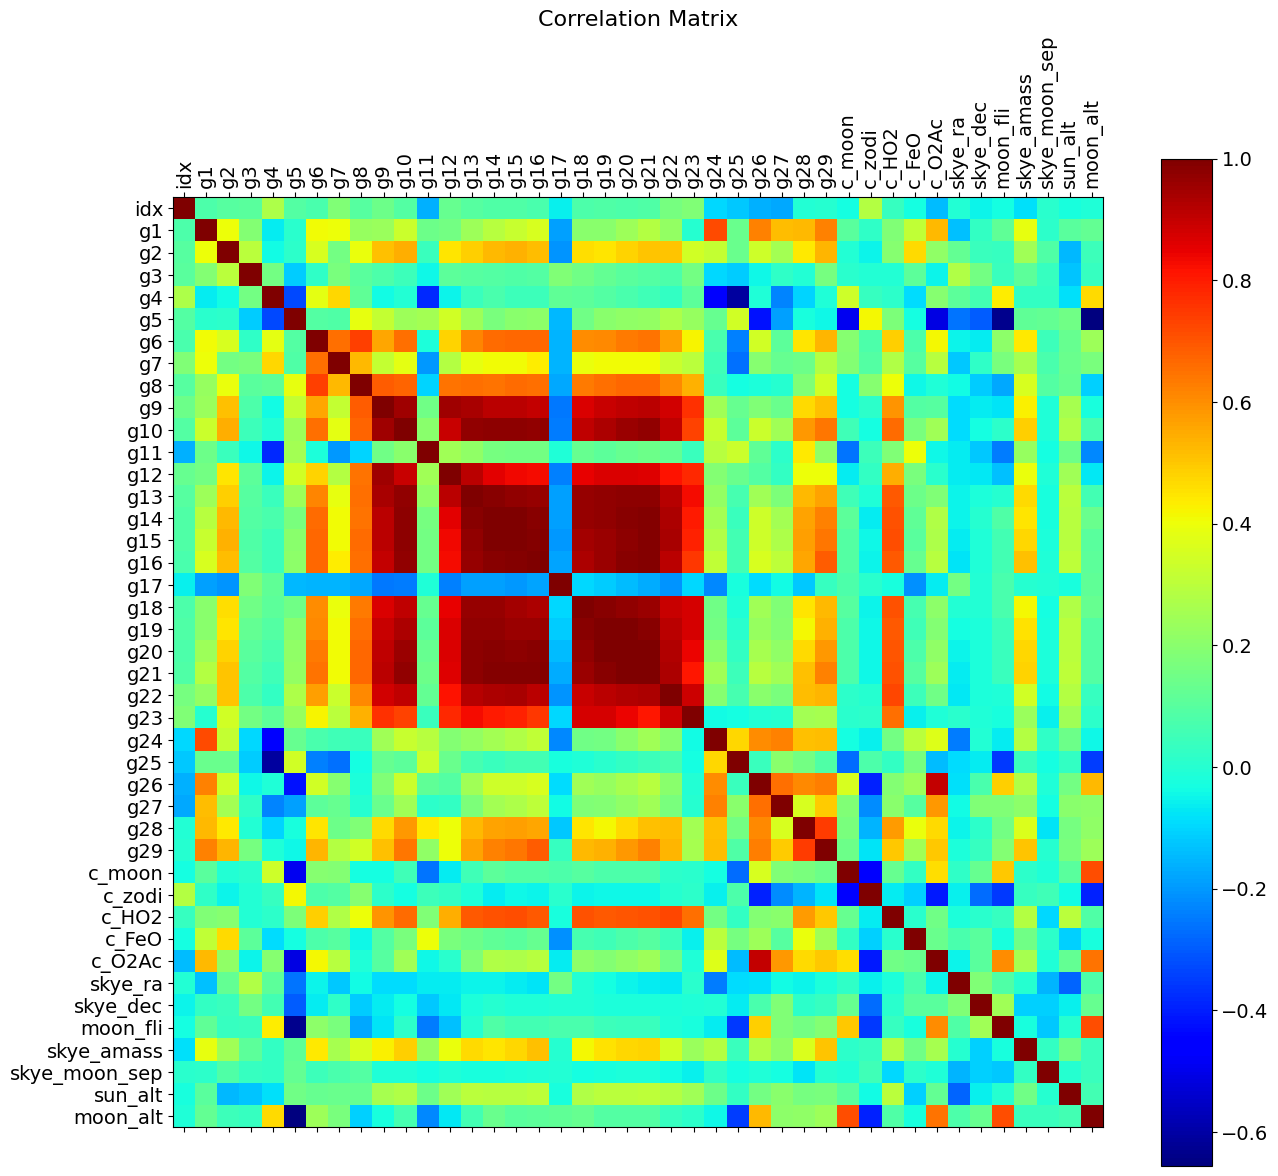

In [56]:

corr_matrix = df.corr(method='spearman')

plt.close()
f = plt.figure(figsize=(15, 13))
plt.matshow(corr_matrix, fignum=f.number, cmap='jet')
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

### Find pairs with high correlation

In [58]:
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > 0.7:
            high_corr_pairs.append((corr_matrix.columns[i], 
                                   corr_matrix.columns[j], 
                                   corr))

# Sort pairs by correlation in descending order
high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

# Print the results
print("Highly correlated pairs (|corr| > 0.7):")
for col1, col2, corr in high_corr_pairs:
    print(f"{col1:6s} - {col2:7s}: {corr:.7f}")

Highly correlated pairs (|corr| > 0.7):
g20    - g21    : 0.9962531
g14    - g15    : 0.9948544
g19    - g20    : 0.9946681
g16    - g21    : 0.9923232
g14    - g21    : 0.9895520
g15    - g21    : 0.9892262
g15    - g16    : 0.9870868
g14    - g20    : 0.9837901
g18    - g19    : 0.9830233
g19    - g21    : 0.9827712
g13    - g14    : 0.9822601
g14    - g16    : 0.9822462
g16    - g20    : 0.9809062
g13    - g20    : 0.9792848
g15    - g20    : 0.9786038
g13    - g21    : 0.9783062
g10    - g15    : 0.9766206
g10    - g14    : 0.9742092
g10    - g13    : 0.9739703
g10    - g16    : 0.9733141
g18    - g20    : 0.9728969
g13    - g15    : 0.9725207
g13    - g19    : 0.9719787
g10    - g21    : 0.9700873
g14    - g19    : 0.9690600
g14    - g18    : 0.9643504
g13    - g18    : 0.9634752
g13    - g16    : 0.9625278
g18    - g21    : 0.9587063
g16    - g19    : 0.9583188
g15    - g19    : 0.9579070
g10    - g20    : 0.9550244
g9     - g12    : 0.9542990
g9     - g10    : 0.9540633
g15    -

### Pair parameter plots

#### Strongly correlated paramters

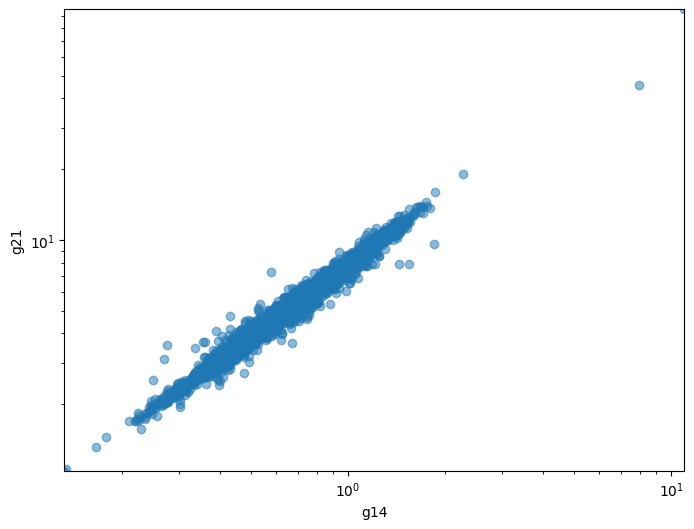

In [64]:
plt.close()
cpair = ['g14', 'g21']

pl = [0, 100]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df[cpair[0]], df[cpair[1]], 'o', alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(cpair[0])
ax.set_ylabel(cpair[1])
ax.set_xlim(np.nanpercentile(df[cpair[0]], pl))
ax.set_ylim(np.nanpercentile(df[cpair[1]], pl))
plt.show()

#### Poorly correlated parameters

/var/folders/sg/qfk9vd6n17g0pvf1kt22r13r0000gn/T/ipykernel_32351/3014547537.py:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(np.nanpercentile(df[cpair[0]], pl))


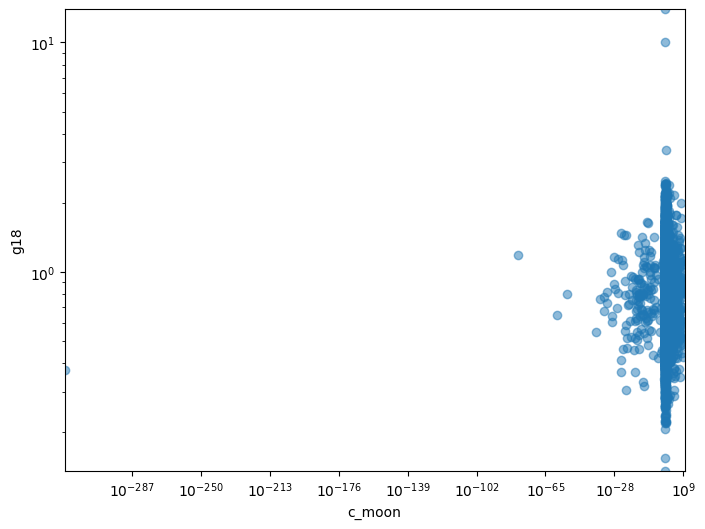

In [65]:
plt.close()

cpair = ['c_moon', 'g18']

pl = [0, 100]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df[cpair[0]], df[cpair[1]], 'o', alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(cpair[0])
ax.set_ylabel(cpair[1])
ax.set_xlim(np.nanpercentile(df[cpair[0]], pl))
ax.set_ylim(np.nanpercentile(df[cpair[1]], pl))
plt.show()

## Technical cells to find some bugs and issues

In [66]:
t_bad = Table.from_pandas(df[df['g5'] < 1e-3])
t_bad['idx', 'moon_fli', 'g5']

idx,moon_fli,g5
int64,float64,float64
0,0.1857,6.9302523617803775e-18
1,0.1868,0.00045500710938699474
2,0.1881,6.4304705591054645e-21
3,0.1893,1.0487622984272123e-10
4,0.1906,2.016226103075909e-18
5,0.1919,7.431110208948745e-17
13,0.2025,0.0006207197032438869
22,0.258,3.9143155938289605e-21
25,0.2611,2.4510734960568732e-18


In [68]:
msk2 = tout['c_zodi'] > 100
np.argwhere(msk2)

tout[146]['c_zodi']

0.8857562860570991